In [2]:
import pyart
import numpy as np
from fix_velocity import driver_fix_velocity

radar = pyart.io.read_cfradial('sample_data/KUNIMI_20240828_140000_EL002_V10.nc')

### plot raw velocity and check velocity in each ray

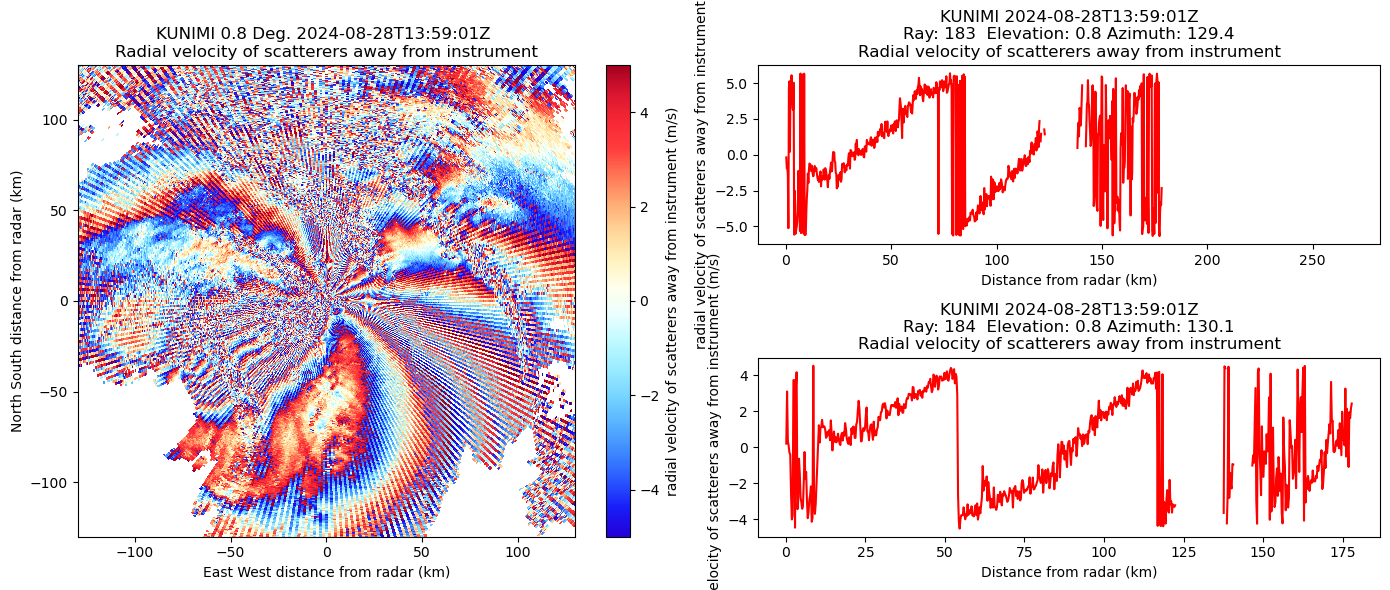

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

display = pyart.graph.RadarDisplay(radar)

## choose sweep and ray
sweep = 0

fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

## 2d plot
ax1 = fig.add_subplot(gs[:, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('V', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax1)

## line plot
display.set_limits((0, 200),  ax=ax)
ray = 183
ax  = fig.add_subplot(gs[0, 1])
display.plot_ray('V', ray, ax=ax, format_str='r-')

ray = 184
ax  = fig.add_subplot(gs[1, 1])
display.plot_ray('V', ray, ax=ax, format_str='r-')


### compute dual prf velocity and nyquist velocity in each ray (C-band)

In [18]:
velocity_dualprf, nyquist_velocity_ray = driver_fix_velocity(radar, band='C',)

radar.add_field_like('V', 'V_dualprf', velocity_dualprf)
print(nyquist_velocity_ray[:10])

[4.5595808  5.69947624 4.5595808  5.69947624 4.5595808  5.69947624
 4.5595808  5.69947624 4.5595808  5.69947624]


### plot dualprf velocity

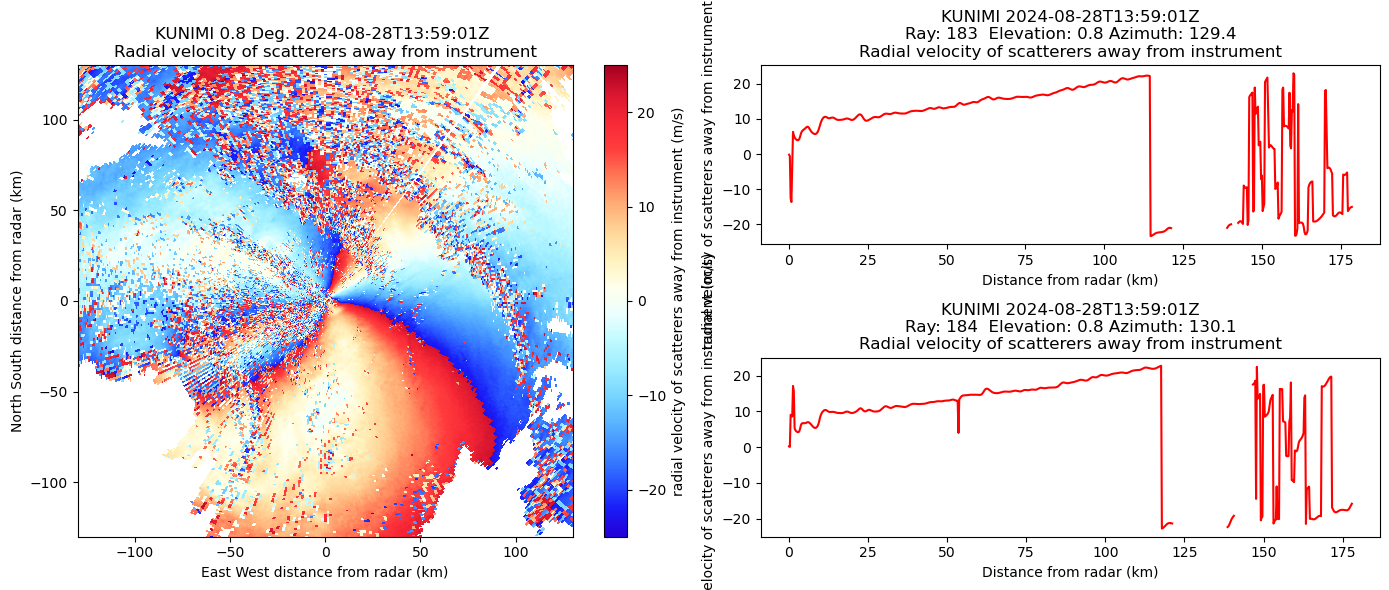

In [21]:
display = pyart.graph.RadarDisplay(radar)

## choose sweep and ray
sweep = 0

fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

## 2d plot
ax1 = fig.add_subplot(gs[:, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('V_dualprf', sweep, cmap="BuDRd18", vmin=-25, vmax=25, ax=ax1)

## line plot
display.set_limits((0, 200),  ax=ax)
ray = 183
ax  = fig.add_subplot(gs[0, 1])
display.plot_ray('V_dualprf', ray, ax=ax, format_str='r-')

ray = 184
ax  = fig.add_subplot(gs[1, 1])
display.plot_ray('V_dualprf', ray, ax=ax, format_str='r-')


### extract raw velocity for specific nyquist velocity

In [22]:
nyq_vel_h, nyq_vel_l = np.max(nyquist_velocity_ray), np.min(nyquist_velocity_ray)
vel_raw = radar.fields['V']['data']

vel_raw_h = vel_raw.copy()
vel_raw_l = vel_raw.copy()

vel_raw_h.mask[ nyquist_velocity_ray == nyq_vel_l ] = True
vel_raw_l.mask[ nyquist_velocity_ray == nyq_vel_h ] = True

radar.add_field_like('V', 'V_nyq_vel_h', vel_raw_h)
radar.add_field_like('V', 'V_nyq_vel_l', vel_raw_l)

### plot raw velocity 

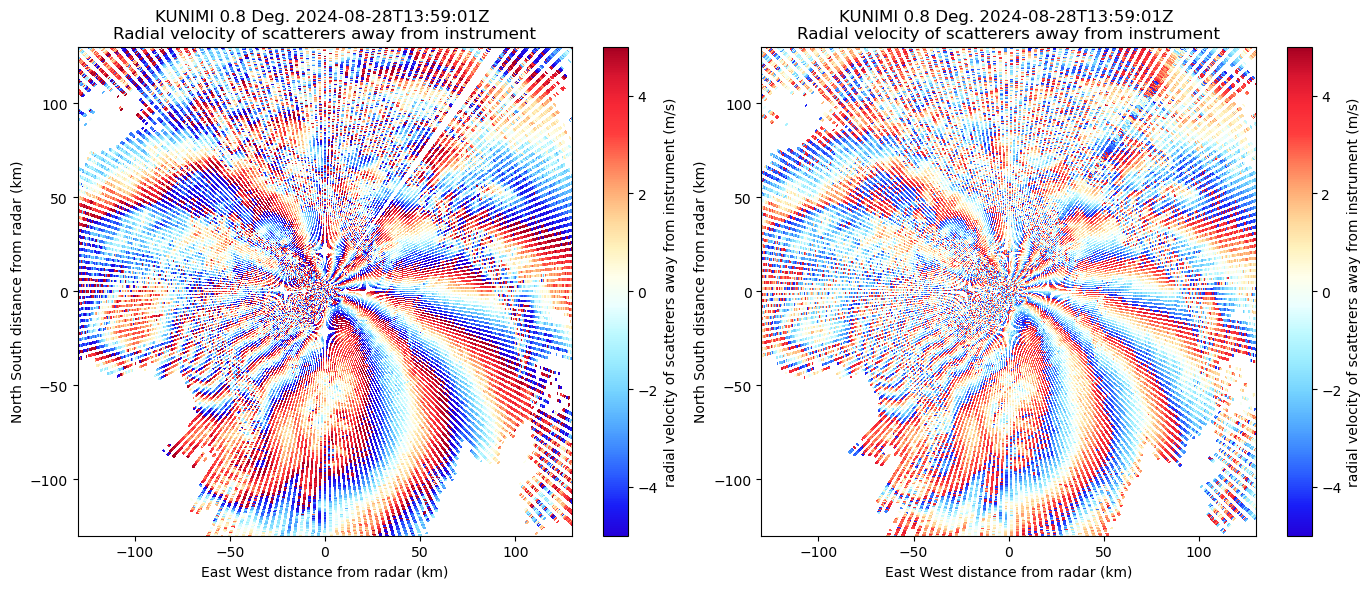

In [23]:
fig = plt.figure(figsize=(14,6), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

## 2d plot
ax1 = fig.add_subplot(gs[0, 0])
display.set_limits((-130, 130), (-130, 130), ax=ax1)
display.plot_ppi('V_nyq_vel_h', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax1)

ax2 = fig.add_subplot(gs[0, 1])
display.set_limits((-130, 130), (-130, 130), ax=ax2)
display.plot_ppi('V_nyq_vel_l', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax2)